# Libraries

In [68]:
# Data manipulation and plots
# ==============================================================================
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# set the default theme of seaborn 
sns.set_theme()

In [69]:
# Custom functions
# ==============================================================================
import db_function_aut as linked
import df_modify as mod

In [70]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data

In [71]:
table = "observation_month"
df  = linked.get_dataFrame_by_table(table)

In [72]:
df_filtered = df[df.eval(" accommodation_type_id == 'ALL'  and destination_id == 'ITG27'  and origin_id == 'IT' and observation_type_id == 'AR'")]

In [73]:
# filter by date, until the end of 2016, before the change of provinces
df = mod.filter_by_date(df_filtered,"2008-01-01","2016-12-01")


df_filtered['date'] = pd.to_datetime( df_filtered['date'], format="%Y-%m-%d")
df_select_date = df_filtered['date'].between('2008-01-01','2016-12-01')
data = df_filtered[df_select_date]
# remove useless columns for the train/test
data.drop(['observation_type_id', 'destination_id', 'origin_id', 'accommodation_type_id'], axis=1, inplace=True)
data

/home/kindaglia/Documents/Statea/FinTech/Predizone/one_field/df_modify.py:22: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_selection = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]
/tmp/ipykernel_9851/3454633728.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['observation_type_id', 'destination_id', 'origin_id', 'accommodation_type_id'], axis=1, inplace=True)


,date,observation
12,2008-01-01,13508
48,2008-02-01,15762
84,2008-03-01,18845
120,2008-04-01,24369
156,2008-05-01,43872
...,...,...
3852,2016-08-01,86144
3906,2016-09-01,56384
3960,2016-10-01,24835
4014,2016-11-01,16696


/tmp/ipykernel_9851/2846142439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')


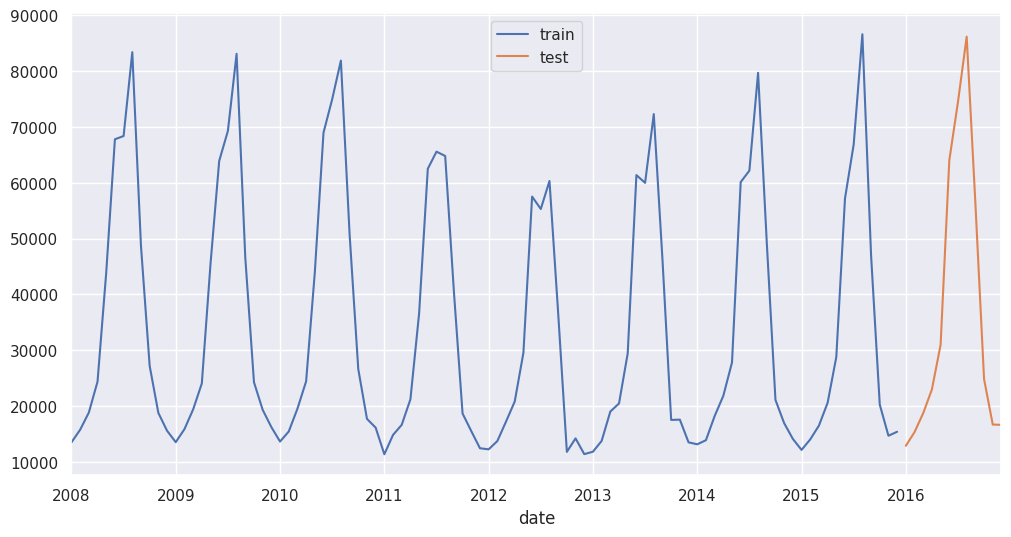

In [74]:
# Data preparation
data.columns = data.columns.str.replace('observation', 'y')
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')

# The last 12 months are used as the test set to evaluate the predictive capacity of the model.
# Split data into train-test

f_train = data[:-12]
f_test  = data[-12:]

f_train_y = f_train['y']
f_test_y  = f_test['y']

# plot
fig, ax=plt.subplots(figsize=(12, 6))
f_train['y'].plot(ax=ax, label='train')
f_test['y'].plot(ax=ax, label='test')
ax.legend();
plt.show()

# ForecasterAutoreg

In [75]:
# Create and train forecaster
forecaster = ForecasterAutoreg(
                regressor =  Ridge(),
                transformer_y = StandardScaler(),
                lags      = 30# The time window that defines the rows of the feature matrix
             )

forecaster.fit(y=f_train_y)

# Predictions

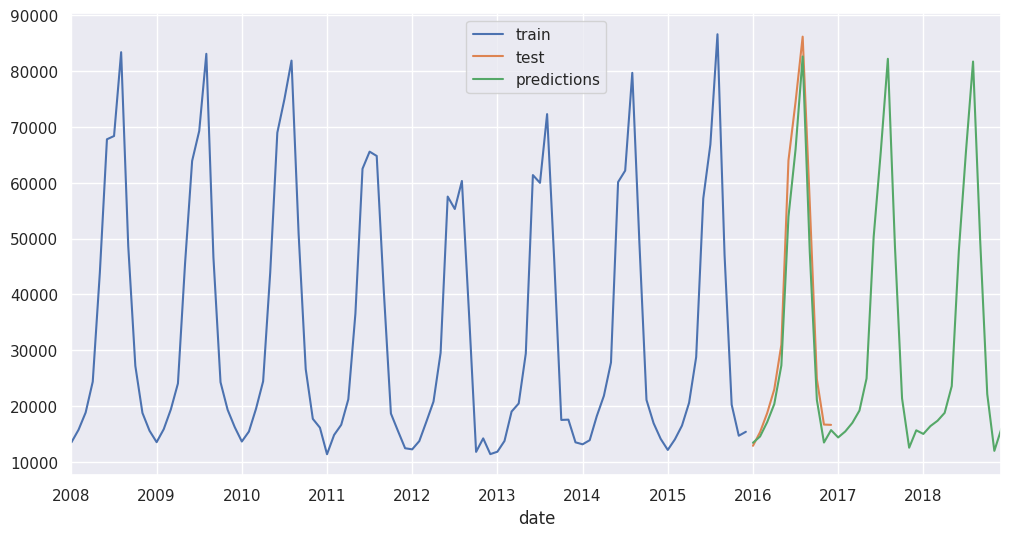

In [76]:
# the 24 months of testing plus the 12 unknowns
steps = 24 + 12

# prediction
f_pred = forecaster.predict(steps=steps)

# plot
fig, ax=plt.subplots(figsize=(12, 6))
f_train['y'].plot(ax=ax, label='train')
f_test['y'].plot(ax=ax, label='test')
f_pred.plot(ax=ax, label='predictions')
ax.legend();

# Prediction error and accuracy in the test set

In [77]:
mse_all = mean_squared_error(f_test_y, f_pred[:-24])
r2_all  = r2_score(f_test_y, f_pred[:-24])
print(" MSE:", mse_all, "  R2:", r2_all) 

 MSE: 26024349.984083947   R2: 0.9584349883870424


# Final model

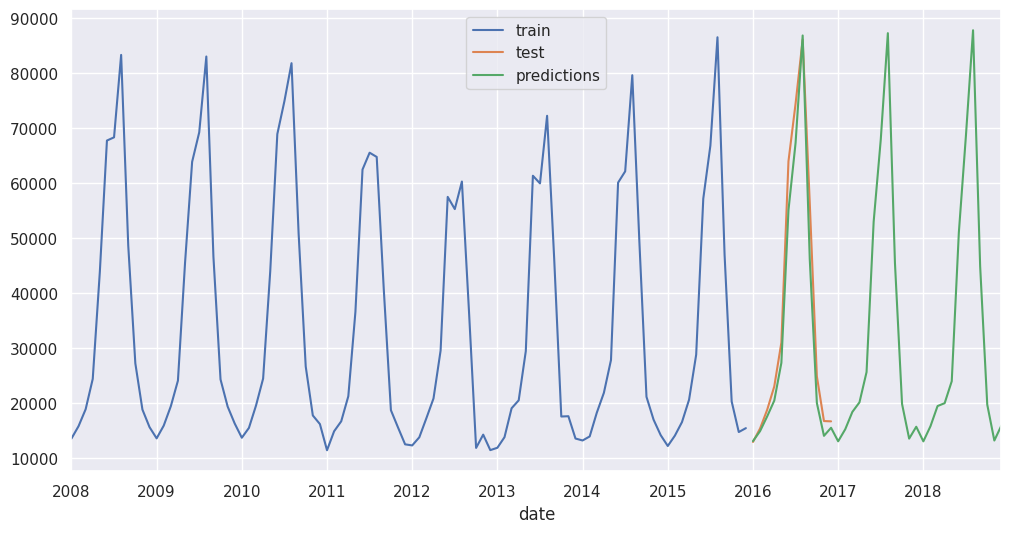

In [78]:
# Create and train forecaster
fa_autoreg = ForecasterAutoreg(regressor = Ridge(alpha=0.001),
                              transformer_y = StandardScaler(),
                              lags = 13)

fa_autoreg.fit(y=f_train_y)


# prediction
fa_pred = fa_autoreg.predict(steps=steps)


# plot
fig, ax=plt.subplots(figsize=(12, 6))
f_train['y'].plot(ax=ax, label='train')
f_test['y'].plot(ax=ax, label='test')
fa_pred.plot(ax=ax, label='predictions')
ax.legend();


In [79]:
# Test error and accuracy
mse_all = mean_squared_error(f_test_y, fa_pred[:-24])
r2_all  = r2_score(f_test_y, fa_pred[:-24])
print(" MSE:", mse_all, "  R2:", r2_all)

 MSE: 24142657.376060963   R2: 0.9614403497179623


# Save and load model

In [80]:
# Create forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data['y'])
forecaster.predict(steps=30)

2017-01-01    13318.42
2017-02-01    14950.37
2017-03-01    15511.56
2017-04-01    20468.52
2017-05-01    29754.15
2017-06-01    56886.37
2017-07-01    60773.96
2017-08-01    68178.32
2017-09-01    41680.51
2017-10-01    19438.33
2017-11-01    16594.65
2017-12-01    13508.68
2018-01-01    14599.42
2018-02-01    15407.89
2018-03-01    20160.84
2018-04-01    24972.07
2018-05-01    43483.79
2018-06-01    66670.72
2018-07-01    72635.61
2018-08-01    82770.10
2018-09-01    51443.72
2018-10-01    25439.76
2018-11-01    18512.21
2018-12-01    16702.27
2019-01-01    13164.41
2019-02-01    14348.40
2019-03-01    14893.68
2019-04-01    18487.54
2019-05-01    20655.06
2019-06-01    30681.70
Freq: MS, Name: pred, dtype: float64

In [81]:
# Save model
save_forecaster(forecaster, file_name='presenze.py', verbose=False)

In [82]:
# Load model
# forecaster_loaded = load_forecaster('forecaster.py')